# Resource Estimates for phase estimation and time evolution

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
colors = ['#4285F4', '#EA4335', '#FBBC04', '#34A853']
import matplotlib as mpl

import numpy as np
from mec_sandia.vasp_utils import read_vasp
from mec_sandia.config import VASP_DATA
from mec_sandia.ft_pw_resource_estimates import pw_qubitization_costs
from mec_sandia.ft_pw_with_projectile import pw_qubitization_with_projectile_costs
import os

In [2]:
# Let's read in the H-He example provided by Sandia
ase_cell = read_vasp(os.path.join(VASP_DATA, "H_2eV_POSCAR"))
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr
volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_elec = np.sum(ase_cell.get_atomic_numbers())
num_nuclei = len(np.where(ase_cell.get_atomic_numbers() == 1)[0])
from mec_sandia.vasp_utils import compute_wigner_seitz_radius
# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))
print("eta = {} ".format(num_elec))

Volume = 358.5599999999998 A^3
rs = 1.383792947036349 bohr
eta = 218 


In [3]:
# Now get costs for phase estimation (without projectile Nuclei)
num_bits_momenta = 6 # Number of bits in each direction for momenta. Note this needs to be increased to 8 or so.
eps_total = 1e-3 # Total allowable error
num_bits_nu = 6 # extra bits for nu 
num_bits_nuc = 20 # extra bits 
toff, qubit = pw_qubitization_costs(np=num_bits_momenta, 
                                    eta=num_elec, 
                                    Omega=volume_bohr, 
                                    eps=eps_total, 
                                    nMc=num_bits_nu, 
                                    nbr=num_bits_nuc, 
                                    L=num_nuclei + 1,  # + 1 is for Helium atom
                                    phase_estimation_costs=True
                                    )
print(f"Phase Estimation: Toffolis = {toff:4.3e}, qubits = {qubit}")
blockencodingtoff, lambdaval, qubit = pw_qubitization_with_projectile_costs(np=num_bits_momenta, 
                                                                            eta=num_elec, 
                                                                            Omega=volume_bohr, 
                                                                            eps=eps_total, 
                                                                            nMc=num_bits_nu, 
                                                                            nbr=num_bits_nuc, 
                                                                            L=num_nuclei, 
                                                                            zeta=2,
                                                                            phase_estimation_costs=False)
print(f"Block encdoing costs: Toffolis = {blockencodingtoff:4.3e}, lambda = {lambdaval:f} qubits = {qubit}")

Phase Estimation: Toffolis = 6.146e+13, qubits = 5642
Block encdoing costs: Toffolis = 2.321e+04, lambda = 1725556.149065 qubits = 5534


In [11]:
# specify parameters for plot
eps_total = np.logspace(-2, -4.4, 8)
tau_vals = [10, 20, 30, 40][::-1]

Total Time Evolution Toffoli =  1.113e+13

Total Time Evolution Toffoli =  1.243e+13

Total Time Evolution Toffoli =  1.371e+13

Total Time Evolution Toffoli =  1.493e+13

Total Time Evolution Toffoli =  1.612e+13

Total Time Evolution Toffoli =  1.729e+13

Total Time Evolution Toffoli =  1.843e+13

Total Time Evolution Toffoli =  1.962e+13

Total Time Evolution Toffoli =  8.346e+12

Total Time Evolution Toffoli =  9.323e+12

Total Time Evolution Toffoli =  1.028e+13

Total Time Evolution Toffoli =  1.120e+13

Total Time Evolution Toffoli =  1.209e+13

Total Time Evolution Toffoli =  1.296e+13

Total Time Evolution Toffoli =  1.382e+13

Total Time Evolution Toffoli =  1.472e+13

Total Time Evolution Toffoli =  5.564e+12

Total Time Evolution Toffoli =  6.216e+12

Total Time Evolution Toffoli =  6.855e+12

Total Time Evolution Toffoli =  7.465e+12

Total Time Evolution Toffoli =  8.060e+12

Total Time Evolution Toffoli =  8.643e+12

Total Time Evolution Toffoli =  9.214e+12

Total Time 

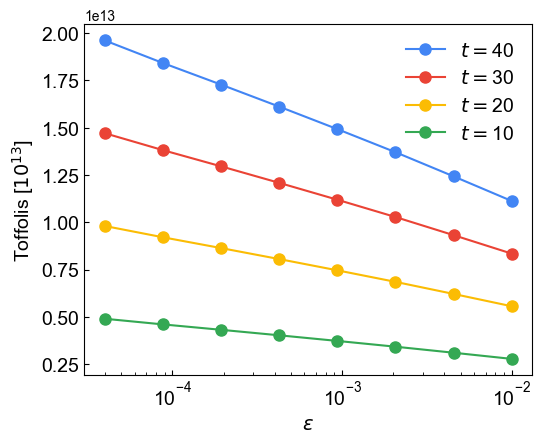

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for cidx, tau in enumerate(tau_vals):
        evolution_costs = []
        for eps in eps_total:
            blockencodingtoff, lambdaval, qubit = pw_qubitization_with_projectile_costs(np=num_bits_momenta, 
                                                                                        eta=num_elec, 
                                                                                        Omega=volume_bohr, 
                                                                                        eps=eps, 
                                                                                        nMc=num_bits_nu, 
                                                                                        nbr=num_bits_nuc, 
                                                                                        L=num_nuclei, 
                                                                                        zeta=2,
                                                                                        phase_estimation_costs=False
                                                                                        )
            # Total toffoli times
            # 2(λt + 1.04(λt)⅓)log(1/ε)⅔
            lambda_by_time = np.abs(tau) * lambdaval
            num_queries_to_block_encoding = 2 * (lambda_by_time + 1.04 * (lambda_by_time)**(1/3)) * np.log2(1/eps)**(2/3)
            print("Total Time Evolution Toffoli = {: 4.3e}".format(num_queries_to_block_encoding * blockencodingtoff))
            print()
            evolution_costs.append(num_queries_to_block_encoding * blockencodingtoff)
    
        ax.semilogx(eps_total, evolution_costs, color=colors[cidx], linestyle='-', label=fr"$t=${tau}", marker='o', markersize=8)

ax.tick_params(which='both', labelsize=14, direction='in')
ax.set_xlabel("$\epsilon$", fontsize=14)
ax.set_ylabel(r"Toffolis [$10^{13}$]", fontsize=14)
ax.tick_params(which='both', labelsize=14, direction='in')
ax.legend(loc='upper right', fontsize=14, ncol=1, frameon=False)
plt.gcf().subplots_adjust(bottom=0.15, left=0.2)
plt.savefig("H2_epsilon_vs_evolution_time.png", format="PNG", dpi=300)
plt.savefig("H2_epsilon_vs_evolution_time.pdf", format="PDF", dpi=300)
plt.show()

In [12]:
# Now let's dow the Deuterium example
ase_cell = read_vasp(os.path.join(VASP_DATA, "D_POSCAR"))
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr
volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_elec = np.sum(ase_cell.get_atomic_numbers())
num_nuclei = len(np.where(ase_cell.get_atomic_numbers() == 1)[0])
print(num_nuclei)
from mec_sandia.vasp_utils import compute_wigner_seitz_radius
# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))
print("eta = {} ".format(num_elec))

Volume = 577.1514824733873 A^3
1729
rs = 0.8132066816006787 bohr
eta = 1729 


In [13]:
# Now get costs for phase estimation (without projectile Nuclei)
num_bits_momenta = 6 # Number of bits in each direction for momenta. Note this needs to be increased to 8 or so.
eps = 1e-3 # Total allowable error
num_bits_nu = 6 # extra bits for nu 
num_bits_nuc = 20 # extra bits 
toff, qubit = pw_qubitization_costs(np=num_bits_momenta, 
                                    eta=num_elec, 
                                    Omega=volume_bohr, 
                                    eps=eps, 
                                    nMc=num_bits_nu, 
                                    nbr=num_bits_nuc, 
                                    L=num_nuclei,  # Just for electrons so all are included
                                    phase_estimation_costs=True
                                    )
print(f"Phase Estimation: Toffolis = {toff:4.3e}, qubits = {qubit}")
blockencodingtoff, lambdaval, qubit = pw_qubitization_with_projectile_costs(np=num_bits_momenta, 
                                                                            eta=num_elec, 
                                                                            Omega=volume_bohr, 
                                                                            eps=eps, 
                                                                            nMc=num_bits_nu, 
                                                                            nbr=num_bits_nuc, 
                                                                            L=num_nuclei - 1, 
                                                                            zeta=1, # proton in a deuterium soup
                                                                            phase_estimation_costs=False)
print(f"Block encdoing costs: Toffolis = {blockencodingtoff:4.3e}, lambda = {lambdaval:f} qubits = {qubit}")

Phase Estimation: Toffolis = 1.939e+16, qubits = 33055
Block encdoing costs: Toffolis = 1.404e+05, lambda = 88135597.460491 qubits = 32923


Total Time Evolution Toffoli =  3.487e+15

Total Time Evolution Toffoli =  3.815e+15

Total Time Evolution Toffoli =  4.130e+15

Total Time Evolution Toffoli =  4.435e+15

Total Time Evolution Toffoli =  4.730e+15

Total Time Evolution Toffoli =  5.017e+15

Total Time Evolution Toffoli =  5.296e+15

Total Time Evolution Toffoli =  5.569e+15

Total Time Evolution Toffoli =  2.615e+15

Total Time Evolution Toffoli =  2.861e+15

Total Time Evolution Toffoli =  3.098e+15

Total Time Evolution Toffoli =  3.326e+15

Total Time Evolution Toffoli =  3.547e+15

Total Time Evolution Toffoli =  3.762e+15

Total Time Evolution Toffoli =  3.972e+15

Total Time Evolution Toffoli =  4.177e+15

Total Time Evolution Toffoli =  1.744e+15

Total Time Evolution Toffoli =  1.908e+15

Total Time Evolution Toffoli =  2.065e+15

Total Time Evolution Toffoli =  2.217e+15

Total Time Evolution Toffoli =  2.365e+15

Total Time Evolution Toffoli =  2.508e+15

Total Time Evolution Toffoli =  2.648e+15

Total Time 

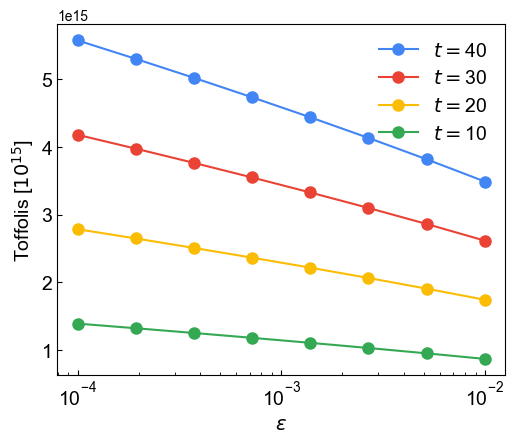

In [16]:
eps_total = np.logspace(-2, -4, 8)
fig, ax = plt.subplots(nrows=1, ncols=1)
for cidx, tau in enumerate(tau_vals):
        evolution_costs = []
        for eps in eps_total:
            blockencodingtoff, lambdaval, qubit = pw_qubitization_with_projectile_costs(np=num_bits_momenta, 
                                                                                        eta=num_elec, 
                                                                                        Omega=volume_bohr, 
                                                                                        eps=eps, 
                                                                                        nMc=num_bits_nu, 
                                                                                        nbr=num_bits_nuc, 
                                                                                        L=num_nuclei - 1, 
                                                                                        zeta=1,
                                                                                        phase_estimation_costs=False
                                                                                        )
            # Total toffoli times
            # 2(λt + 1.04(λt)⅓)log(1/ε)⅔
            lambda_by_time = np.abs(tau) * lambdaval
            num_queries_to_block_encoding = 2 * (lambda_by_time + 1.04 * (lambda_by_time)**(1/3)) * np.log2(1/eps)**(2/3)
            print("Total Time Evolution Toffoli = {: 4.3e}".format(num_queries_to_block_encoding * blockencodingtoff))
            print()
            evolution_costs.append(num_queries_to_block_encoding * blockencodingtoff)
    
        ax.semilogx(eps_total, evolution_costs, color=colors[cidx], linestyle='-', label=fr"$t=${tau}", marker='o', markersize=8)

ax.tick_params(which='both', labelsize=14, direction='in')
ax.set_xlabel("$\epsilon$", fontsize=14)
ax.set_ylabel(r"Toffolis [$10^{15}$]", fontsize=14)
ax.tick_params(which='both', labelsize=14, direction='in')
ax.legend(loc='upper right', fontsize=14, ncol=1, frameon=False)
plt.gcf().subplots_adjust(bottom=0.15, left=0.2)
plt.savefig("D_epsilon_vs_evolution_time.png", format="PNG", dpi=300)
plt.savefig("D_epsilon_vs_evolution_time.pdf", format="PDF", dpi=300)